In [387]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from tqdm._tqdm_notebook import tqdm_notebook as tqdm 

# Reading data

In [388]:
path_data_geo =  '../../data/interim/Brazil/election_data/2018/polling_places/polling_places.csv'
data_geo = pd.read_csv(path_data_geo)
data_geo.head(1)

,id_unico,local_unico,lat,lon,fetched_address,precision,LOCAL_VOTACAO,ENDERECO,CEP,COD_LOCALIDADE_IBGE,LOCALIDADE_LOCAL_VOTACAO,SGL_UF,ZONA,BAIRRO_ZONA_SEDE,LATITUDE_ZONA,LONGITUDE_ZONA,NUM_SECAO,NUM_LOCAL,BAIRRO_LOCAL_VOT,COUNTRY
0,14385,"CRECHE DONA MARIA DE ARAUJO CARNEIRO, RUA NOSS...",-5.193051,-39.304486,"R. Dr. Sebastião Cavalcante, 58 - Monteiro de ...",ROOFTOP,CRECHE DONA MARIA DE ARAUJO CARNEIRO,RUA NOSSA SENHORA DA NATIVIDADE SN,62660000,2313757,UMIRIM,CE,23,CENTRO,NaN,NaN,231,1015,CENTRO-SEDE,BRASIL


In [430]:
city_maps = gpd.read_file("../../data/raw/Brazil/census_2010/digital_mesh/municipios/BRMUE250GC_SIR.shp",  encoding = 'utf-8')
city_maps["NM_MUNICIP"] = city_maps.NM_MUNICIP.astype(str)
city_maps["CD_GEOCMU"] = city_maps.CD_GEOCMU.astype(str)

# Adding buffer to limits in order to get points in the border

In [ ]:
city_maps['geometry'] = tqdm(city_maps['geometry'].buffer(0.05))

# Creating a geopandas dataframe from the locations

In [431]:
geometry = [ Point( ( row.lon, row.lat ) ) for index, row in data_geo.iterrows() ]
data_geo = gpd.GeoDataFrame( data_geo, geometry = geometry )
data_geo.crs = {'init': 'EPSG:4326'}
data_geo.head(1)

,id_unico,local_unico,lat,lon,fetched_address,precision,LOCAL_VOTACAO,ENDERECO,CEP,COD_LOCALIDADE_IBGE,...,ZONA,BAIRRO_ZONA_SEDE,LATITUDE_ZONA,LONGITUDE_ZONA,NUM_SECAO,NUM_LOCAL,BAIRRO_LOCAL_VOT,COUNTRY,geometry,city_limits
0,14385,"CRECHE DONA MARIA DE ARAUJO CARNEIRO, RUA NOSS...",-5.193051,-39.304486,"R. Dr. Sebastião Cavalcante, 58 - Monteiro de ...",ROOFTOP,CRECHE DONA MARIA DE ARAUJO CARNEIRO,RUA NOSSA SENHORA DA NATIVIDADE SN,62660000,2313757,...,23,CENTRO,NaN,NaN,231,1015,CENTRO-SEDE,BRASIL,POINT (-39.3044857 -5.193051000000001),out


# Verifiying if locations are inside city limits

In [432]:
to_concat = []
for index, location in tqdm(data_geo.iterrows()):
    
    city = city_maps[city_maps.CD_GEOCMU == str(location['COD_LOCALIDADE_IBGE'])].reset_index(drop=True)
    city_polygon = city['geometry'].values[0]
    point = location['geometry']
    if point.within(city_polygon):
        to_concat = to_concat + ['in']
    else:
        to_concat = to_concat + ['out']
        
data_geo['city_limits'] = to_concat

# Total number of locations in and out of city limits

In [433]:
data_geo.city_limits.value_counts()

in     85475
out     9186
Name: city_limits, dtype: int64

# Total number TSE of locations in and out of city limits

In [434]:
data_geo[data_geo['precision'] == 'TSE'].city_limits.value_counts()

in     22298
out       50
Name: city_limits, dtype: int64

# Total number of ROOFTOP locations in and out of city limits

In [435]:
data_geo[data_geo['precision'] == 'ROOFTOP'].city_limits.value_counts()

in     32301
out      720
Name: city_limits, dtype: int64

# Total number of Range Interpolated locations in and out of city limits

In [436]:
data_geo[data_geo['precision'] == 'RANGE_INTERPOLATED'].city_limits.value_counts()

in     801
out     82
Name: city_limits, dtype: int64

# Total number of GEOMETRIC CENTER locations in and out of city limits

In [437]:
data_geo[data_geo['precision'] == 'GEOMETRIC_CENTER'].city_limits.value_counts()

in     20402
out     1181
Name: city_limits, dtype: int64

# Total number of APPROXIMATED locations in and out of city limits

In [438]:
data_geo[data_geo['precision'] == 'APPROXIMATE'].city_limits.value_counts()

in     9673
out    6777
Name: city_limits, dtype: int64

# Checking TSE out city locations

In [444]:
tse_data_geo = data_geo[data_geo['precision'] == 'TSE']
out_tse_data_geo = tse_data_geo[tse_data_geo['city_limits'] == 'out']
out_tse_data_geo[['id_unico','LOCALIDADE_LOCAL_VOTACAO','COD_LOCALIDADE_IBGE', 'city_limits','geometry']].head()

,id_unico,LOCALIDADE_LOCAL_VOTACAO,COD_LOCALIDADE_IBGE,city_limits,geometry
5715,44223,JOVIÂNIA,5212105,out,POINT (-49.44769893 -17.49894819)
12484,52990,BOM JESUS,2401701,out,POINT (-35.20936307 -5.7837593)
13353,81676,PAIM FILHO,4313607,out,POINT (-51.76349310000001 -23.7080073)
15260,61198,BENJAMIN CONSTANT,1300607,out,POINT (-69.43897681999999 -4.24987485)
20289,15336,CARACARAÍ,1400209,out,POINT (-60.6646203 2.8298891)


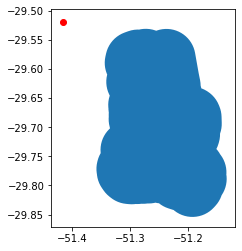

False

In [443]:
%matplotlib inline
from shapely.affinity import translate
import matplotlib.pyplot as plt

a = city_maps[city_maps['CD_GEOCMU']=='4314803']
b = data_geo[data_geo['id_unico']==16871]

f, ax = plt.subplots(1)

a.plot(ax=ax)
b.plot(ax=ax, color='red')

plt.show()
a['geometry'].values[0].contains(b['geometry'].values[0])